Project Details :
1. Data Understanding
2. Creating Dataset and visualization
3. Building a Model and training

1. Dataset Reading and understanding

Importing all libraries for project

In [ ]:
import pathlib
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
!pip install tensorflow==2.13.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_dataset = pathlib.Path('/content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train')
test_dataset = pathlib.Path('/content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Test')

In [ ]:
# Count the number of images in the training directory
train_image_count = len(list(train_dataset.glob('*/*.jpg')))

# Print the count of images in the training directory
print("Number of image files in the training directory:", train_image_count)

# Count the number of images in the test directory
test_image_count = len(list(test_dataset.glob('*/*.jpg')))

# Print the count of images in the test directory
print("Number of image files in the test directory:", test_image_count)

Number of image files in the training directory: 2239
Number of image files in the test directory: 118


2. Creating Dataset and visualization

Found 29239 files belonging to 9 classes.


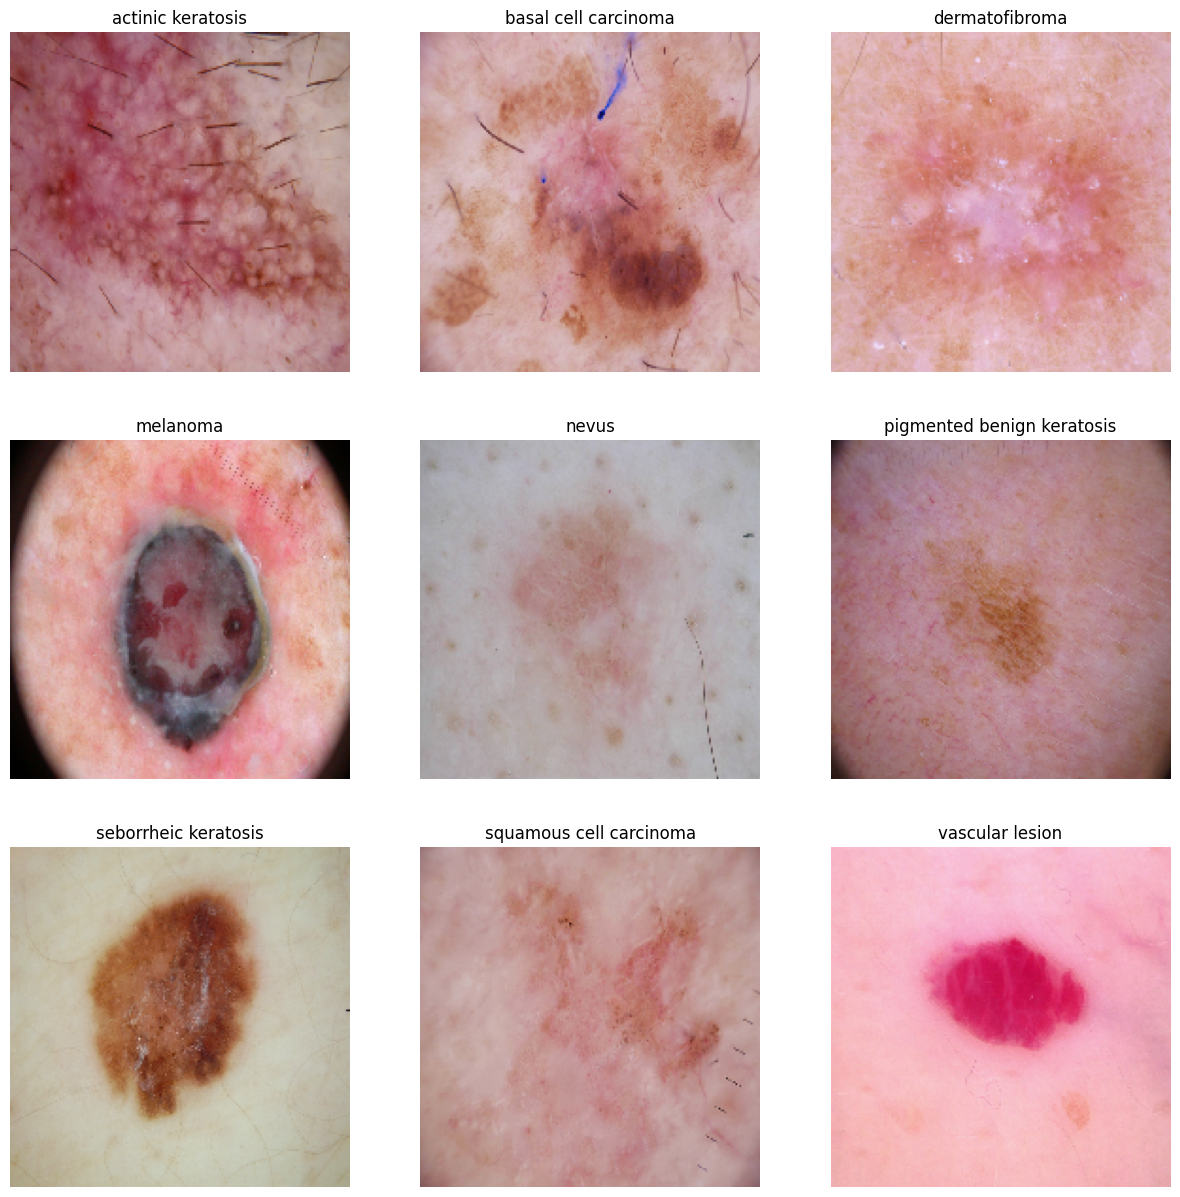

In [ ]:
# Visualizing One Instance from Each Class in the Dataset

# Using image_dataset_from_directory() to create a dataset that yields batches of labeled images
# label_mode is set to 'categorical' for one-hot encoding of class labels
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123
)

# Get the names of all the classes (skin cancer types)
class_names = image_dataset.class_names

# Dictionary to store image paths for each class
files_path_dict = {}

# Loop through each class to gather image paths
for c in class_names:
    files_path_dict[c] = list(map(lambda x: str(train_dataset) + '/' + c + '/' + x, os.listdir(str(train_dataset) + '/' + c)))

# Visualize an image from each class
plt.figure(figsize=(15, 15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)

    # Load and display the image
    plt.imshow(load_img(path_list[0], target_size=(180, 180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
def class_distribution_count(directory):
    # Initialize a list to store image counts for each class
    count = []

    # Count the number of images in each class directory
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))

    # Get the names of the classes (sub-directories)
    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

    # Create a DataFrame with class names and corresponding image counts
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Images'])

    # Sort the DataFrame in ascending order of image counts
    df = df.sort_values(by='No. of Images', ascending=True)

    # Return the sorted DataFrame
    return df

# Call the function to get the class distribution and image count
class_distribution_df = class_distribution_count(train_dataset)

# Display the DataFrame
class_distribution_df

,Class,No. of Images
1,seborrheic keratosis,77
7,dermatofibroma,95
0,actinic keratosis,114
2,vascular lesion,139
6,squamous cell carcinoma,181
5,nevus,357
3,basal cell carcinoma,376
8,melanoma,438
4,pigmented benign keratosis,462


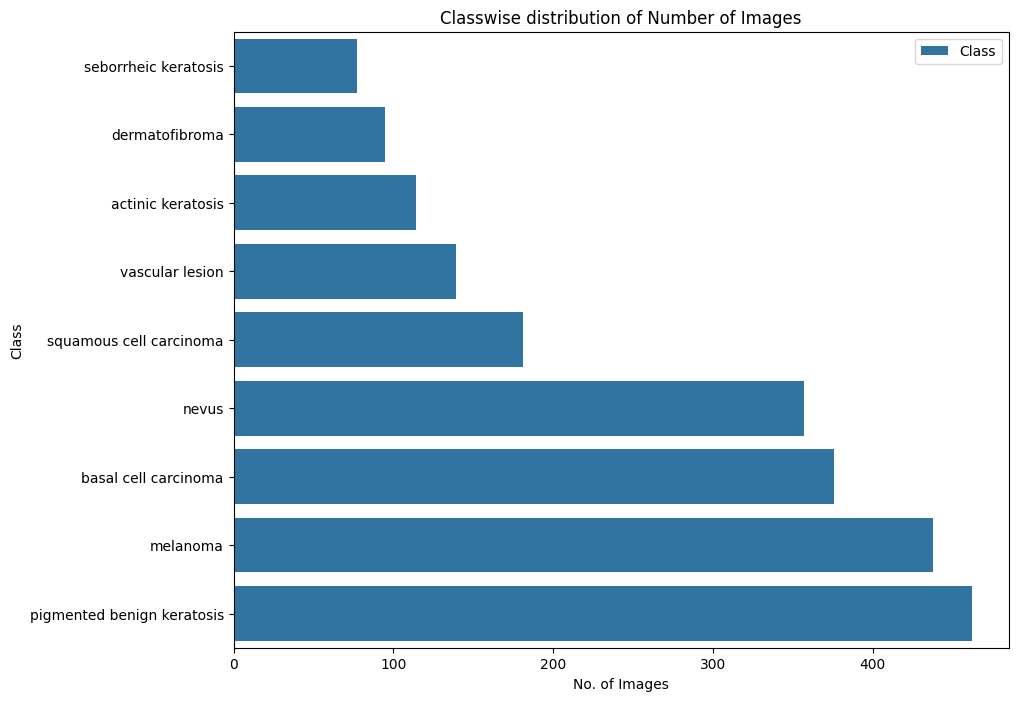

In [ ]:
import seaborn as sns

# Set the size of the plot figure
plt.figure(figsize=(10, 8))

# Create a bar plot using seaborn package
sns.barplot(x="No. of Images", y="Class", data= class_distribution_df, label="Class")

# Add a title to the plot
plt.title("Classwise distribution of Number of Images")

# Display the plot
plt.show()

2.1 Handling imbalances

In [ ]:
# Install Augmentor library
!pip install -q Augmentor

# Define the path to the training dataset
path_to_training_dataset = "/content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/"

# Import the Augmentor library
import Augmentor

# Loop through each class and perform data augmentation
for i in class_names:
    # Create an Augmentor pipeline for the current class
    p = Augmentor.Pipeline(path_to_training_dataset + i)

    # Apply rotation augmentation with specified parameters
    p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)

    # Generate and save 500 augmented samples for each class
    p.sample(500)  # Adding 500 samples per class to ensure class balance


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC942BC9A0>: 100%|██████████| 500/500 [00:28<00:00, 17.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC942EE530>: 100%|██████████| 500/500 [00:28<00:00, 17.72 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC9672C580>: 100%|██████████| 500/500 [00:27<00:00, 18.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AFC942EE800>: 100%|██████████| 500/500 [02:09<00:00,  3.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7AFD1E4EA3E0>: 100%|██████████| 500/500 [01:53<00:00,  4.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AFC966CF760>: 100%|██████████| 500/500 [00:28<00:00, 17.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AFC817B75E0>: 100%|██████████| 500/500 [01:00<00:00,  8.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFD1E4EA3E0>: 100%|██████████| 500/500 [00:26<00:00, 19.07 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC965C6BC0>: 100%|██████████| 500/500 [00:28<00:00, 17.41 Samples/s]


In [ ]:

# Count the number of image files in the 'output' subdirectories of each class
train_image_count = len(list(train_dataset.glob('*/output/*.jpg')))

# Print the total count of augmented images
print("Total number of augmented images:", train_image_count)

Total number of augmented images: 31500


3. Building a model and training it

In [ ]:
#Model Building

# Create a Training Dataset

# Use image_dataset_from_directory() to create a training dataset from the training directory
# Batch size: 32 images per batch
# Image size: 180x180 pixels
# Label mode: 'categorical' for one-hot encoded class labels
# Seed: 123 for random shuffling consistency
# Subset: "training" to select the training subset of the dataset
# Validation split: 20% of the data is used for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset, batch_size=32, image_size=(180, 180), label_mode='categorical',
    seed=123, subset="training", validation_split=0.2
)

Found 33739 files belonging to 9 classes.
Using 26992 files for training.


In [ ]:
# Create a Validation Dataset

# Use image_dataset_from_directory() to create a validation dataset from the training directory
# Subset: "validation" to select the validation subset of the dataset
# Validation split: 20% of the data is used for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset, batch_size=32, image_size=(180, 180), label_mode='categorical',
    seed=123, subset="validation", validation_split=0.2
)

In [ ]:
# Define the appropriate number of processes that are free for working using AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the training dataset in memory after loading images from disk during the first epoch
# This helps improve data loading speed for subsequent epochs
train_ds = train_ds.cache()

# Shuffle the training dataset to introduce randomness during training
# and prevent the model from memorizing the order of examples
train_ds = train_ds.shuffle(1000)

# Prefetch data for training to overlap data preprocessing and model execution
# This can lead to better GPU utilization and overall training performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset in memory
# Caching the validation data can help improve evaluation speed
val_ds = val_ds.cache()

# Prefetch data for validation
# Similar to training, prefetching can enhance validation performance
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

CNN Model Architecture

In [ ]:
# CNN Model Architecture

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer: Scale input pixel values to the [0, 1] range
# Removed 'experimental' namespace for newer Keras versions
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer: Convert multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer: Fully connected layer with 128 units and ReLU activation
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
# Softmax scales logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

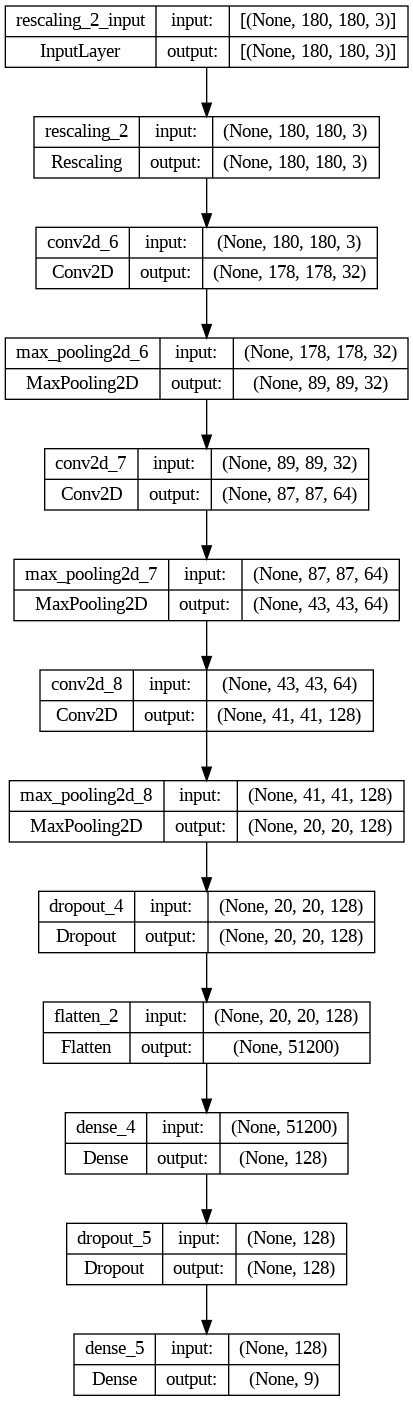

In [ ]:
# Visualizing the Model Architecture

# Import the necessary function from TensorFlow Keras utilities
from tensorflow.keras.utils import plot_model

# Plot the model architecture and save it as an image file
# Set show_shapes=True to display the shapes of the input/output tensors in the plot
# Set show_layer_names=True to display the names of the layers in the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
#Compile the Model

# Compile the model with Adam optimization
# Adam is a stochastic gradient descent method with adaptive estimation of moments
# Categorical crossentropy is used as the loss function for multi-class classification
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback is used to save the model or weights at specific intervals
# It saves the best model based on the validation accuracy
# The saved model can be loaded later to continue training from the saved state
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback is used to stop training when a monitored metric stops improving
# It helps prevent overfitting by stopping training when validation accuracy plateaus
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

Epochs

In [ ]:
# Train the Model

# Set the number of training epochs
epochs = 35

# Train the model using the training dataset and validate on the validation dataset
# Use the ModelCheckpoint and EarlyStopping callbacks defined earlier
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint, earlystop])

Epoch 1/35


Plotting training curves

In [ ]:
# Plot the Training Curves

# Get the range of epochs where training was stopped by EarlyStopping
epochs_range = range(earlystop.stopped_epoch + 1)

# Create a figure with two subplots for accuracy and loss
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

# Plot Model Accuracy
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

# Display the plots
plt.show()

In [ ]:
from glob import glob

# Construct the path to a test image
test_image_path = os.path.join(test_dataset, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[-1], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)